In [1]:
import time
import itertools

import pandas as pd
from simulation_helpers import (one_sim_mode, one_sim_mode_serial, 
                                generate_gaussian_instance_nonlinear_interaction_simple)
from multiprocessing import Pool

from functools import partial

/Users/yilingh/Desktop/PhD/SI_Codes/SI-Interaction/env3/lib/python3.9/site-packages/regreg/atoms/slope.py:16: UserWarning: unable to import isotonic regression from sklearn, using a pure python implementation
  warn('unable to import isotonic regression from sklearn, using a pure python implementation')


In [11]:
def interaction_filter_vary_mode(nsim=100, use_MLE=True, parallel=True,
                                 ncores=8):
    """
    Compare to R randomized lasso
    """

    # Operating characteristics
    oper_char = {}
    oper_char["coverage rate"] = []
    oper_char["avg length"] = []
    oper_char["method"] = []
    oper_char["F1 score interaction"] = []
    oper_char["|G|"] = []
    oper_char["mode"] = []
    oper_char["SNR"] = []
    p = 30
    SNR = 1
    intercept_flag = True
    
    """
    GOOD RESULT:
    1. 
    p = 30
    SNR = 1
    intercept_flag = True
    ### Partially correlated
    (design, data_interaction, Y, Y_mean, data_combined,
                 groups, active, active_inter_adj, active_inter_list) \
                    = inst(n=500, p_nl=p, p_l=0, s_l=0,
                           nknots=6, degree=2, SNR=SNR, rho=0.5, rho_noise=0.5,
                           center=False, scale=False, random_signs=True,
                           intercept=intercept_flag, structure='weakhierarchy', 
                           s_interaction=10, interaction_signal=2)
    weight_frac = 2
                           
    2. 
    p = 30
    SNR = 0.5
    intercept_flag = True
    ### Fully correlated
    (design, data_interaction, Y, Y_mean, data_combined,
                 groups, active, active_inter_adj, active_inter_list) \
                    = inst(n=500, p_nl=p, p_l=0, s_l=0,
                           nknots=6, degree=2, SNR=SNR, rho=0.5, rho_noise=0.5,
                           center=False, scale=False, random_signs=True,
                           intercept=intercept_flag, structure='weakhierarchy', 
                           s_interaction=10, interaction_signal=2)
    weight_frac = 2
    """
    if parallel:
        oper_char_list = []
        
    for mode in ["stronghierarchy", "weakhierarchy", "allpairs"]:  
        if parallel:
            with Pool(ncores) as pool:
                results = pool.map(partial(one_sim_mode, SNR=SNR, 
                                           intercept_flag=intercept_flag,
                                           p=p, use_MLE=use_MLE, mode=mode,
                                           weight_frac=1.5, 
                        inst=generate_gaussian_instance_nonlinear_interaction_simple,
                                           rho=0.5, rho_noise=0.5, full_corr=False),
                                   list(range(nsim)))
            oper_char_list = oper_char_list + results
        else:
            for i in range(nsim):
                print(i, "th simulation for mode:", mode)
                
                one_sim_mode_serial(SNR=SNR, intercept_flag=intercept_flag,
                             p=p, oper_char=oper_char, use_MLE=use_MLE,
                             mode=mode)
    if parallel:
        oper_char_list = list(itertools.chain(*oper_char_list))
        oper_char = pd.DataFrame(oper_char_list)
        oper_char.columns = ["coverage rate","avg length","F1 score interaction",
                             "method", "|G|", "mode", "SNR"]
        return oper_char
    else:
        return pd.DataFrame(oper_char)

In [12]:
# 328s for 8 iters with 8 cores
start = time.time()
oper_char_mode = interaction_filter_vary_mode(8, use_MLE=True, parallel=False)
end = time.time()
print(end-start)

0 th simulation for mode: stronghierarchy
Equally spaced quantile knots used.
DS Selection Size: 15
Naive Selection Size: 14
1 th simulation for mode: stronghierarchy
Equally spaced quantile knots used.
DS Selection Size: 7
Naive Selection Size: 7
2 th simulation for mode: stronghierarchy
Equally spaced quantile knots used.
DS Selection Size: 0
Naive Selection Size: 8
3 th simulation for mode: stronghierarchy
Equally spaced quantile knots used.
DS Selection Size: 6
Naive Selection Size: 8
4 th simulation for mode: stronghierarchy
Equally spaced quantile knots used.
DS Selection Size: 9
Naive Selection Size: 15
5 th simulation for mode: stronghierarchy
Equally spaced quantile knots used.
DS Selection Size: 7
Naive Selection Size: 8
6 th simulation for mode: stronghierarchy
Equally spaced quantile knots used.
DS Selection Size: 12
Naive Selection Size: 8
7 th simulation for mode: stronghierarchy
Equally spaced quantile knots used.
DS Selection Size: 12
Naive Selection Size: 6
0 th simula

In [5]:
def interaction_filter_vary_SNR(nsim=100, use_MLE=True, parallel=True,
                                ncores=8):
    """
    Compare to R randomized lasso
    """

    # Operating characteristics
    oper_char = {}
    oper_char["coverage rate"] = []
    oper_char["avg length"] = []
    oper_char["method"] = []
    oper_char["F1 score interaction"] = []
    oper_char["|G|"] = []
    oper_char["mode"] = []
    oper_char["SNR"] = []
    
    p = 30
    mode = 'weakhierarchy'
    intercept_flag = True
    
    """
    GOOD RESULT:
    1. 
    p = 30
    SNR = 1
    intercept_flag = True
    ### Partially correlated
    (design, data_interaction, Y, Y_mean, data_combined,
                 groups, active, active_inter_adj, active_inter_list) \
                    = inst(n=500, p_nl=p, p_l=0, s_l=0,
                           nknots=6, degree=2, SNR=SNR, rho=0.5, rho_noise=0.5,
                           center=False, scale=False, random_signs=True,
                           intercept=intercept_flag, structure='weakhierarchy', 
                           s_interaction=10, interaction_signal=2)
    weight_frac = 2
                           
    2. 
    p = 30
    SNR = 0.5
    intercept_flag = True
    ### Fully correlated
    (design, data_interaction, Y, Y_mean, data_combined,
                 groups, active, active_inter_adj, active_inter_list) \
                    = inst(n=500, p_nl=p, p_l=0, s_l=0,
                           nknots=6, degree=2, SNR=SNR, rho=0.5, rho_noise=0.5,
                           center=False, scale=False, random_signs=True,
                           intercept=intercept_flag, structure='weakhierarchy', 
                           s_interaction=10, interaction_signal=2)
    weight_frac = 2
    """
    if parallel:
        oper_char_list = []
        
    for SNR in [0.1, 0.5, 1, 2, 5]:  
        if parallel:
            with Pool(ncores) as pool:
                results = pool.map(partial(one_sim_mode, SNR=SNR, 
                                           intercept_flag=intercept_flag,
                                           p=p, use_MLE=use_MLE, mode=mode,
                                           weight_frac=1.5),
                                   list(range(nsim)))
            oper_char_list = oper_char_list + results
        else:
            for i in range(nsim):
                print(i, "th simulation for mode:", mode)
                
                one_sim_mode_serial(SNR=SNR, intercept_flag=intercept_flag,
                             p=p, oper_char=oper_char, use_MLE=use_MLE,
                             mode=mode)
    if parallel:
        oper_char_list = list(itertools.chain(*oper_char_list))
        oper_char = pd.DataFrame(oper_char_list)
        oper_char.columns = ["coverage rate","avg length","F1 score interaction",
                             "method", "|G|", "mode", "SNR"]
        return oper_char
    else:
        return pd.DataFrame(oper_char)

In [7]:
oper_char_SNR = interaction_filter_vary_SNR(80, use_MLE=True, parallel=True)

/Users/yilingh/Desktop/PhD/SI_Codes/SI-Interaction/env3/lib/python3.9/site-packages/regreg/atoms/slope.py:16: UserWarning: unable to import isotonic regression from sklearn, using a pure python implementation
  warn('unable to import isotonic regression from sklearn, using a pure python implementation')
/Users/yilingh/Desktop/PhD/SI_Codes/SI-Interaction/env3/lib/python3.9/site-packages/regreg/atoms/slope.py:16: UserWarning: unable to import isotonic regression from sklearn, using a pure python implementation
  warn('unable to import isotonic regression from sklearn, using a pure python implementation')
/Users/yilingh/Desktop/PhD/SI_Codes/SI-Interaction/env3/lib/python3.9/site-packages/regreg/atoms/slope.py:16: UserWarning: unable to import isotonic regression from sklearn, using a pure python implementation
  warn('unable to import isotonic regression from sklearn, using a pure python implementation')
/Users/yilingh/Desktop/PhD/SI_Codes/SI-Interaction/env3/lib/python3.9/site-packages/r

Equally spaced quantile knots used.
DS Selection Size: 23
Equally spaced quantile knots used.
DS Selection Size: 9
Equally spaced quantile knots used.
DS Selection Size: 15
Naive Selection Size: 11
Equally spaced quantile knots used.
DS Selection Size: 36
Equally spaced quantile knots used.
DS Selection Size: 33
Equally spaced quantile knots used.
Equally spaced quantile knots used.
DS Selection Size: 14
Naive Selection Size: 19
Equally spaced quantile knots used.
DS Selection Size: 29
Equally spaced quantile knots used.
DS Selection Size: 26
Equally spaced quantile knots used.
DS Selection Size: 58
Naive Selection Size: 9
Equally spaced quantile knots used.
DS Selection Size: 20
Equally spaced quantile knots used.
DS Selection Size: 48
Equally spaced quantile knots used.
DS Selection Size: 9
Equally spaced quantile knots used.
DS Selection Size: 42
Equally spaced quantile knots used.
DS Selection Size: 15
Equally spaced quantile knots used.
DS Selection Size: 18
Equally spaced quantil

/Users/yilingh/Desktop/PhD/SI_Codes/SI-Interaction/env3/lib/python3.9/site-packages/regreg/atoms/slope.py:16: UserWarning: unable to import isotonic regression from sklearn, using a pure python implementation
  warn('unable to import isotonic regression from sklearn, using a pure python implementation')
/Users/yilingh/Desktop/PhD/SI_Codes/SI-Interaction/env3/lib/python3.9/site-packages/regreg/atoms/slope.py:16: UserWarning: unable to import isotonic regression from sklearn, using a pure python implementation
  warn('unable to import isotonic regression from sklearn, using a pure python implementation')
/Users/yilingh/Desktop/PhD/SI_Codes/SI-Interaction/env3/lib/python3.9/site-packages/regreg/atoms/slope.py:16: UserWarning: unable to import isotonic regression from sklearn, using a pure python implementation
  warn('unable to import isotonic regression from sklearn, using a pure python implementation')
/Users/yilingh/Desktop/PhD/SI_Codes/SI-Interaction/env3/lib/python3.9/site-packages/r

Equally spaced quantile knots used.
DS Selection Size: 44
Naive Selection Size: 54
Equally spaced quantile knots used.
DS Selection Size: 61
Naive Selection Size: 53
Equally spaced quantile knots used.
DS Selection Size: 58
Naive Selection Size: 59
Equally spaced quantile knots used.
DS Selection Size: 37
Naive Selection Size: 46
Equally spaced quantile knots used.
DS Selection Size: 50
Naive Selection Size: 27
Equally spaced quantile knots used.
DS Selection Size: 56
Naive Selection Size: 36
Equally spaced quantile knots used.
DS Selection Size: 56
Naive Selection Size: 61
Equally spaced quantile knots used.
DS Selection Size: 46
Naive Selection Size: 51
Equally spaced quantile knots used.
DS Selection Size: 25
Naive Selection Size: 25
Equally spaced quantile knots used.
DS Selection Size: 72
Naive Selection Size: 36
Equally spaced quantile knots used.
DS Selection Size: 47
Naive Selection Size: 60
Equally spaced quantile knots used.
DS Selection Size: 26
Naive Selection Size: 44
Equa

/Users/yilingh/Desktop/PhD/SI_Codes/SI-Interaction/env3/lib/python3.9/site-packages/regreg/atoms/slope.py:16: UserWarning: unable to import isotonic regression from sklearn, using a pure python implementation
  warn('unable to import isotonic regression from sklearn, using a pure python implementation')
/Users/yilingh/Desktop/PhD/SI_Codes/SI-Interaction/env3/lib/python3.9/site-packages/regreg/atoms/slope.py:16: UserWarning: unable to import isotonic regression from sklearn, using a pure python implementation
  warn('unable to import isotonic regression from sklearn, using a pure python implementation')
/Users/yilingh/Desktop/PhD/SI_Codes/SI-Interaction/env3/lib/python3.9/site-packages/regreg/atoms/slope.py:16: UserWarning: unable to import isotonic regression from sklearn, using a pure python implementation
  warn('unable to import isotonic regression from sklearn, using a pure python implementation')
/Users/yilingh/Desktop/PhD/SI_Codes/SI-Interaction/env3/lib/python3.9/site-packages/r

Equally spaced quantile knots used.
DS Selection Size: 99
Naive Selection Size: 67
Equally spaced quantile knots used.
DS Selection Size: 47
Naive Selection Size: 59
Equally spaced quantile knots used.
DS Selection Size: 93
Naive Selection Size: 67
Equally spaced quantile knots used.
DS Selection Size: 66
Naive Selection Size: 50
Equally spaced quantile knots used.
DS Selection Size: 18
Naive Selection Size: 23
Equally spaced quantile knots used.
DS Selection Size: 105
Naive Selection Size: 44
Equally spaced quantile knots used.
DS Selection Size: 81
Naive Selection Size: 46
Equally spaced quantile knots used.
DS Selection Size: 69
Naive Selection Size: 49
Equally spaced quantile knots used.
DS Selection Size: 40
Naive Selection Size: 46
Equally spaced quantile knots used.
DS Selection Size: 57
Naive Selection Size: 84
Equally spaced quantile knots used.
DS Selection Size: 75
Naive Selection Size: 44
Equally spaced quantile knots used.
DS Selection Size: 23
Naive Selection Size: 43
Equ

/Users/yilingh/Desktop/PhD/SI_Codes/SI-Interaction/env3/lib/python3.9/site-packages/regreg/atoms/slope.py:16: UserWarning: unable to import isotonic regression from sklearn, using a pure python implementation
  warn('unable to import isotonic regression from sklearn, using a pure python implementation')
/Users/yilingh/Desktop/PhD/SI_Codes/SI-Interaction/env3/lib/python3.9/site-packages/regreg/atoms/slope.py:16: UserWarning: unable to import isotonic regression from sklearn, using a pure python implementation
  warn('unable to import isotonic regression from sklearn, using a pure python implementation')
/Users/yilingh/Desktop/PhD/SI_Codes/SI-Interaction/env3/lib/python3.9/site-packages/regreg/atoms/slope.py:16: UserWarning: unable to import isotonic regression from sklearn, using a pure python implementation
  warn('unable to import isotonic regression from sklearn, using a pure python implementation')
/Users/yilingh/Desktop/PhD/SI_Codes/SI-Interaction/env3/lib/python3.9/site-packages/r

Equally spaced quantile knots used.
DS Selection Size: 92
Naive Selection Size: 54
Equally spaced quantile knots used.
DS Selection Size: 88
Naive Selection Size: 76
Equally spaced quantile knots used.
DS Selection Size: 39
Naive Selection Size: 49
Equally spaced quantile knots used.
DS Selection Size: 84
Naive Selection Size: 99
Equally spaced quantile knots used.
DS Selection Size: 95
Naive Selection Size: 88
Equally spaced quantile knots used.
DS Selection Size: 48
Naive Selection Size: 110
Equally spaced quantile knots used.
DS Selection Size: 87
Naive Selection Size: 91
Equally spaced quantile knots used.
DS Selection Size: 98
Naive Selection Size: 90
Equally spaced quantile knots used.
DS Selection Size: 64
Naive Selection Size: 101
Equally spaced quantile knots used.
DS Selection Size: 92
Naive Selection Size: 104
Equally spaced quantile knots used.
DS Selection Size: 93
Naive Selection Size: 86
Equally spaced quantile knots used.
DS Selection Size: 80
Naive Selection Size: 57
E

/Users/yilingh/Desktop/PhD/SI_Codes/SI-Interaction/env3/lib/python3.9/site-packages/regreg/atoms/slope.py:16: UserWarning: unable to import isotonic regression from sklearn, using a pure python implementation
  warn('unable to import isotonic regression from sklearn, using a pure python implementation')
/Users/yilingh/Desktop/PhD/SI_Codes/SI-Interaction/env3/lib/python3.9/site-packages/regreg/atoms/slope.py:16: UserWarning: unable to import isotonic regression from sklearn, using a pure python implementation
  warn('unable to import isotonic regression from sklearn, using a pure python implementation')
/Users/yilingh/Desktop/PhD/SI_Codes/SI-Interaction/env3/lib/python3.9/site-packages/regreg/atoms/slope.py:16: UserWarning: unable to import isotonic regression from sklearn, using a pure python implementation
  warn('unable to import isotonic regression from sklearn, using a pure python implementation')
/Users/yilingh/Desktop/PhD/SI_Codes/SI-Interaction/env3/lib/python3.9/site-packages/r

Equally spaced quantile knots used.
DS Selection Size: 99
Naive Selection Size: 112
Equally spaced quantile knots used.
DS Selection Size: 135
Naive Selection Size: 146
Equally spaced quantile knots used.
DS Selection Size: 111
Naive Selection Size: 101
Equally spaced quantile knots used.
DS Selection Size: 106
Naive Selection Size: 127
Equally spaced quantile knots used.
DS Selection Size: 99
Naive Selection Size: 121
Equally spaced quantile knots used.
DS Selection Size: 104
Naive Selection Size: 126
Equally spaced quantile knots used.
DS Selection Size: 89
Naive Selection Size: 123
Equally spaced quantile knots used.
DS Selection Size: 114
Naive Selection Size: 116
Equally spaced quantile knots used.
DS Selection Size: 113
Naive Selection Size: 127
Equally spaced quantile knots used.
DS Selection Size: 125
Naive Selection Size: 108
Equally spaced quantile knots used.
DS Selection Size: 87
Naive Selection Size: 90
Equally spaced quantile knots used.
DS Selection Size: 94
Naive Select

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
def plotting(oper_char_df, x_axis='p', hue='method'):
    oper_char_df_copy = oper_char_df.copy()
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(15, 6))

    # print("Mean coverage rate/length:")
    # print(oper_char_df.groupby([x_axis, hue]).mean())
    my_palette = {"MLE": "#48c072",
                  "Naive": "#fc5a50",
                  "Data Splitting": "#03719c"}

    alias = {"stronghierarchy": "Strong",
             "weakhierarchy": "Weak",
             "allpairs": "All"}
    if x_axis == 'mode':
        oper_char_df_copy['mode'] = oper_char_df_copy['mode'].map(alias)

    cov_plot = sns.boxplot(y=oper_char_df_copy["coverage rate"],
                           x=oper_char_df_copy[x_axis],
                           hue=oper_char_df_copy[hue],
                           palette=my_palette,
                           orient="v", ax=ax1,
                           showmeans=True,
                           linewidth=1)
    cov_plot.set(title='Coverage')
    cov_plot.set_ylim(0., 1.05)
    # plt.tight_layout()
    cov_plot.axhline(y=0.9, color='k', linestyle='--', linewidth=1)
    # ax1.set_ylabel("")  # remove y label, but keep ticks
    ax1.set_xlabel(x_axis)

    len_plot = sns.boxplot(y=oper_char_df_copy["avg length"],
                           x=oper_char_df_copy[x_axis],
                           hue=oper_char_df_copy[hue],
                           palette=my_palette,
                           orient="v", ax=ax2,
                           linewidth=1)
    len_plot.set(title='Length')
    # len_plot.set_ylim(0, 100)
    # len_plot.set_ylim(3.5, 7.8)
    # plt.tight_layout()
    # ax2.set_ylabel("")  # remove y label, but keep ticks
    ax2.set_xlabel(x_axis)

    handles, labels = ax2.get_legend_handles_labels()
    # fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.2)
    fig.subplots_adjust(bottom=0.15)
    fig.legend(handles, labels, loc='lower center', ncol=4)

    F1_plot = sns.boxplot(y=oper_char_df_copy["F1 score interaction"],
                          x=oper_char_df_copy[x_axis],
                          hue=oper_char_df_copy[hue],
                          palette=my_palette,
                          orient="v", ax=ax3,
                          linewidth=1)
    F1_plot.set(title='F1 score')
    ax3.set_xlabel(x_axis)

    size_plot = sns.boxplot(y=oper_char_df_copy["|G|"],
                            x=oper_char_df_copy[x_axis],
                            hue=oper_char_df_copy[hue],
                            palette=my_palette,
                            orient="v", ax=ax4,
                            linewidth=1)
    size_plot.set(title='|G|')
    ax4.set_xlabel(x_axis)

    cov_plot.legend_.remove()
    len_plot.legend_.remove()
    F1_plot.legend_.remove()
    size_plot.legend_.remove()

    # plt.suptitle("Changing n,p")
    plt.subplots_adjust(wspace=0.25, hspace=0.2)
    plt.show()

In [6]:
plotting(oper_char_df=oper_char_SNR,
         x_axis="SNR",
         hue="method")

NameError: name 'oper_char_SNR' is not defined

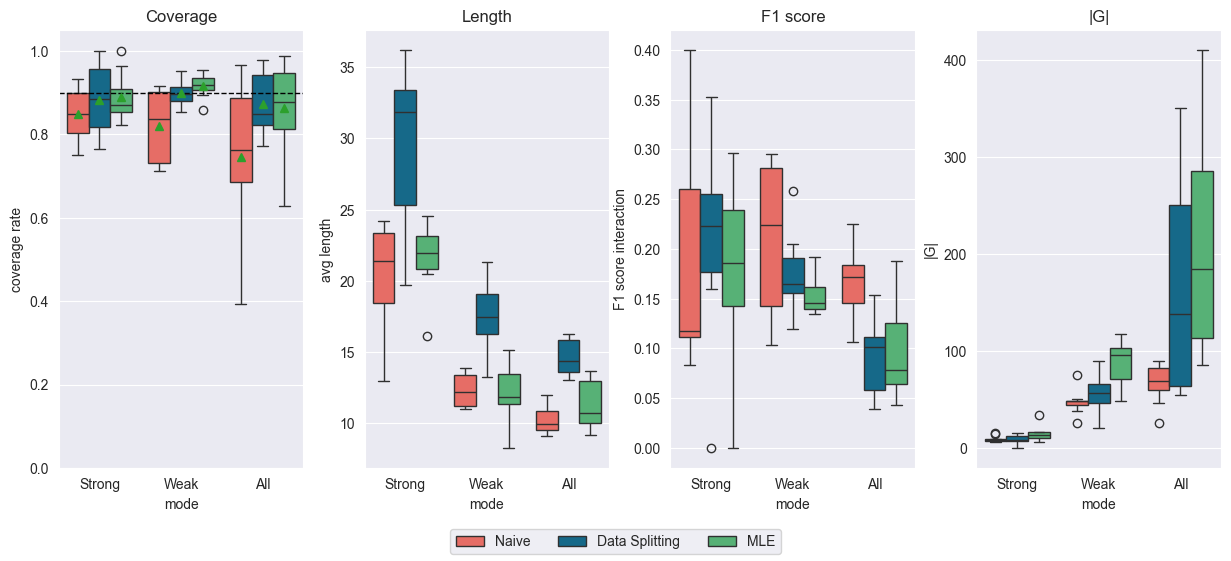

In [13]:
plotting(oper_char_df=oper_char_mode,
         x_axis="mode",
         hue="method")